### Qiskit 102: Running and Optimizing on IBM Quantum Systems

#### Ritajit Majumdar, IBM Quantum

The fundamental unit you will primarily work with in Qiskit is the `QuantumCircuit` object. The basic workflow to using Qiskit consists of four stages, often called <a href="https://docs.quantum.ibm.com/guides/intro-to-patterns">Qiskit patterns</a>: 

- **Step 1: Map classical inputs to a quantum problem**
  - involves making different quantum circuits which represent the problem/algorithm that you are solving
- **Step 2: Optimize circuits for quantum hardware execution**
    - optimize your quantum circuit by transpilation and implementation of error mitigation techniques
- **Step 3: Execute using Qiskit primitives**
    - run the circuits as a job or set of jobs on real hardware
- **Step 4: Post-process results**
    - post process the outcome of the execution and return result in classical format

#### Getting Started

To install Qiskit and the Qiskit IBM Runtime (used to access IBM Quantum hardware), run the following commands:

```
pip install qiskit
pip install qiskit[visualization]
pip install qiskit-ibm-runtime
pip install qiskit-aer
```

The `[visualization]` suffix tells `pip` to install optional dependencies needed for Qiskit visualization functionality, such as drawing circuits with [Matplotlib](https://matplotlib.org/).

#### Primitives

Qiskit introduces abstractions called <a href="https://docs.quantum.ibm.com/api/qiskit/primitives">primitives</a> for encapsulating the output of a quantum circuit. Currently, there are two primitives:

- **Sampler**: The output of the circuit is a probability distribution over measurement outcomes.
- **Estimator**: The output of the circuit is the expectation value of an observable, which must be provided in addition to the circuit.

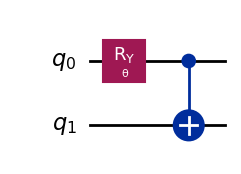

In [17]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter('θ')
circuit = QuantumCircuit(2)
circuit.ry(theta, 0)
circuit.cx(0,1)

circuit.draw("mpl")

#### The Estimator Primitive

Let's begin with understanding how to use the `Estimator` primitive.  To start, we'll need to define the observable(s) we want to measure the expectation values of.  The observable is a quantum operator that can be represented using one of several classes from the `qiskit.quantum_info` module.  For this example we'll use a `SparsePauliOp` object to represent the observable $\langle II +XX -YY + ZZ\rangle$.

In [18]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["II", "XX", "YY", "ZZ"], coeffs=[1, 1, -1, 1])

Let us measure the expectation value for a set of parameters.

In [19]:
import numpy as np
params = np.linspace(0, np.pi, 10)
params

array([0.        , 0.34906585, 0.6981317 , 1.04719755, 1.3962634 ,
       1.74532925, 2.0943951 , 2.44346095, 2.7925268 , 3.14159265])

In [20]:
from qiskit_aer.primitives import EstimatorV2

estimator = EstimatorV2()
pub = (circuit, observable, params)

job = estimator.run([pub])
result = job.result()[0]
print(result)

PubResult(data=DataBin(evs=np.ndarray(<shape=(10,), dtype=float64>), stds=np.ndarray(<shape=(10,), dtype=float64>), shape=(10,)), metadata={'target_precision': 0.0, 'circuit_metadata': {}, 'simulator_metadata': {'time_taken_parameter_binding': 0.00012425, 'max_memory_mb': 32768, 'time_taken_execute': 0.002025666, 'omp_enabled': True, 'max_gpu_memory_mb': 0, 'parallel_experiments': 1}})


In [29]:
ideal_expvals = []
for i, val in enumerate(params):
    ideal_expvals.append(round(result.data.evs[i],3))
    print(f"Expectation Value of <II+XX-YY+ZZ> for parameter {val} = {result.data.evs[i]:.3f}")

Expectation Value of <II+XX-YY+ZZ> for parameter 0.0 = 2.000
Expectation Value of <II+XX-YY+ZZ> for parameter 0.3490658503988659 = 2.684
Expectation Value of <II+XX-YY+ZZ> for parameter 0.6981317007977318 = 3.286
Expectation Value of <II+XX-YY+ZZ> for parameter 1.0471975511965976 = 3.732
Expectation Value of <II+XX-YY+ZZ> for parameter 1.3962634015954636 = 3.970
Expectation Value of <II+XX-YY+ZZ> for parameter 1.7453292519943295 = 3.970
Expectation Value of <II+XX-YY+ZZ> for parameter 2.0943951023931953 = 3.732
Expectation Value of <II+XX-YY+ZZ> for parameter 2.443460952792061 = 3.286
Expectation Value of <II+XX-YY+ZZ> for parameter 2.792526803190927 = 2.684
Expectation Value of <II+XX-YY+ZZ> for parameter 3.141592653589793 = 2.000


#### Running on (fake) hardware

We'll now execute this circuit on real hardware using a Runtime primitive.  To avoid the queue we shall use `FakeSherbrooke`.

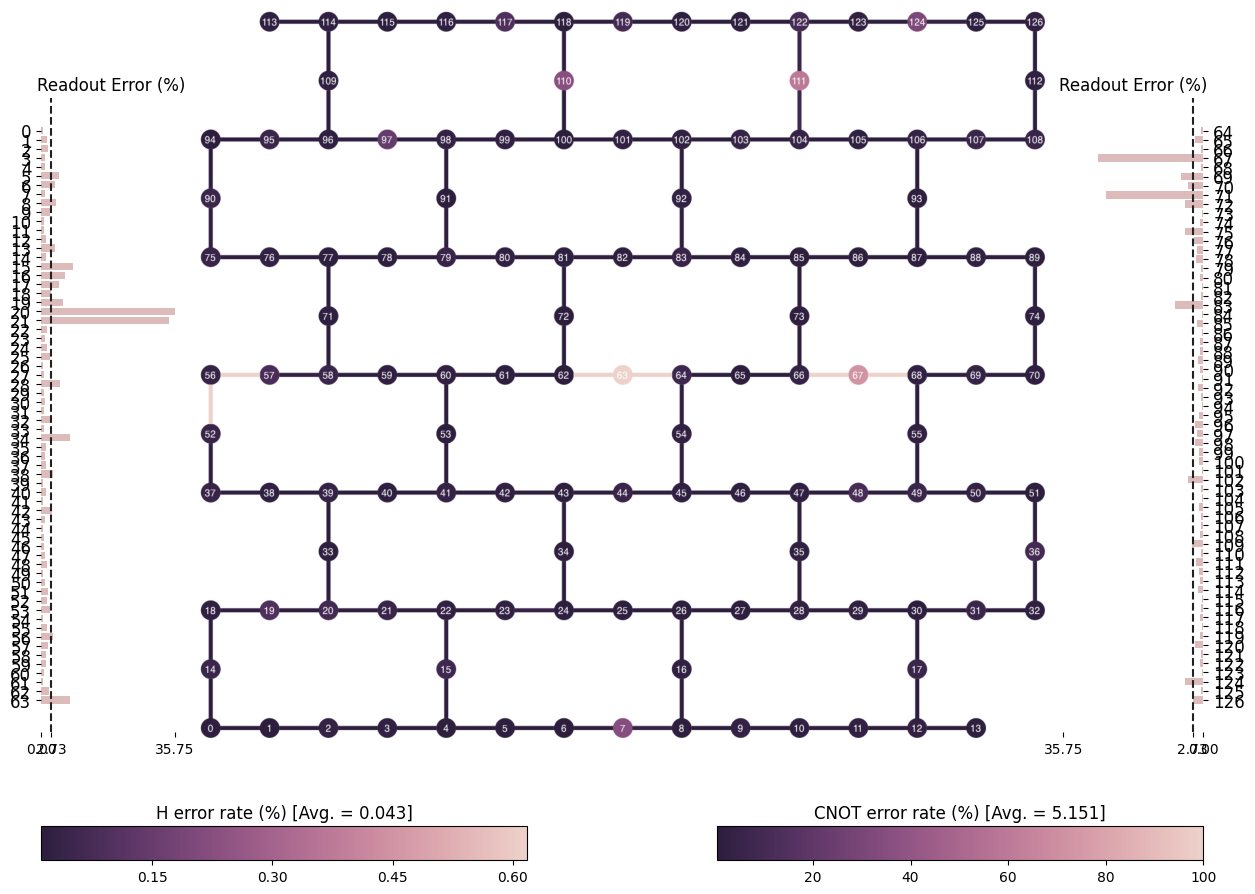

In [32]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit.visualization import plot_error_map

backend = FakeSherbrooke()
plot_error_map(backend, show_title=False)

##### Transpilation

Now we'll run our job on hardware.  However first we must ensure that this circuit is written in terms of the *Instruction Set Architecture* (ISA) of the backend.  This essentially means the circuit must be written in terms of the available basis gates of the backend we will submit to.

In [33]:
backend.configuration().basis_gates

['ecr', 'id', 'rz', 'sx', 'x']

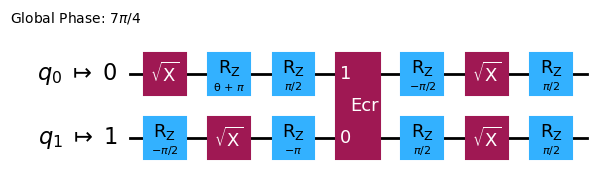

In [58]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from time import time

# Create a staged pass manager which will translate the circuit in terms of the basis gates of the backend
pm_l1 = generate_preset_pass_manager(optimization_level=1, backend=backend)
start_l1 = time()
transpiled_circuit_l1 = pm_l1.run(circuit)
end_l1 = time()

transpiled_circuit_l1.draw('mpl', idle_wires=False)


In [50]:
# Get the qubit layout from the transpiled circuit
layout = transpiled_circuit_l1.layout.final_index_layout()
print(transpiled_circuit_l1.num_qubits)
print(layout)

127
[0, 1]


In [51]:
# Ensure the observables are formatted to respect this layout.  This will insert Identity gates on qubits where no expectation value is specified
observables_l1 = observable.apply_layout(transpiled_circuit_l1.layout)
print(observables_l1)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXX', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYY', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j])


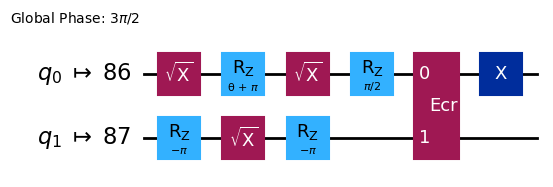

In [59]:
# Create a staged pass manager which will translate the circuit in terms of the basis gates of the backend
pm_l2 = generate_preset_pass_manager(optimization_level=2, backend=backend)
start_l2 = time()
transpiled_circuit_l2 = pm_l2.run(circuit)
end_l2 = time()

transpiled_circuit_l2.draw('mpl', idle_wires=False)

In [56]:
# Get the qubit layout from the transpiled circuit
layout = transpiled_circuit_l2.layout.final_index_layout()
print(layout)

[86, 87]


In [57]:
# Ensure the observables are formatted to respect this layout.  This will insert Identity gates on qubits where no expectation value is specified
observables_l2 = observable.apply_layout(transpiled_circuit_l2.layout)
print(observables_l2)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYYIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j])


In [61]:
print(f"Time taken for level 1 transpilation: {end_l1-start_l1:.3f}")
print(f"Time taken for level 2 transpilation: {end_l2-start_l2:.3f}")

Time taken for level 1 transpilation: 0.017
Time taken for level 2 transpilation: 0.019


**Why did the layout change from [0,1] to [86,87] when using higher optimization level?**

In [63]:
print(f'2-qubit error of [1,0] is {backend.properties().gate_error('ecr',[1,0]):.3f}')
print(f'2-qubit error of [86,87] is {backend.properties().gate_error('ecr',[86,87]):.3f}')

2-qubit error of [1,0] is 0.006
2-qubit error of [86,87] is 0.004


In [65]:
from qiskit_ibm_runtime import EstimatorV2
hw_estimator = EstimatorV2(mode=backend)

pubs = [(transpiled_circuit_l1, observables_l1, params),(transpiled_circuit_l2, observables_l2, params)]

job = hw_estimator.run(pubs)
result = job.result()

In [66]:
l1_expvals = []
l2_expvals = []

for i, val in enumerate(params):
    l1_expvals.append(round(result[0].data.evs[i],3))
    l2_expvals.append(round(result[1].data.evs[i],3))

/var/folders/29/5g097jln3fx21kr9g9vfc4540000gn/T/ipykernel_18837/2036968238.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)


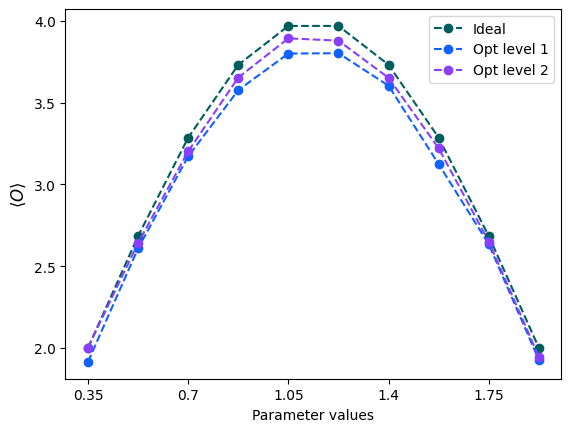

In [77]:
import matplotlib.pyplot as plt

ax = plt.gca()
plt.plot(range(len(params)), ideal_expvals, 'o--', color="#005d5d", label='Ideal')
plt.plot(range(len(params)), l1_expvals, 'o--', color="#0f62fe", label='Opt level 1')
plt.plot(range(len(params)), l2_expvals, 'o--', color="#8a3ffc", label='Opt level 2')
plt.legend()
ax.set_ylabel(r'$\langle O \rangle$', fontsize=12)

xticks = [round(i,2) for i in params]
ax.set_xticklabels(xticks)
ax.set_xlabel('Parameter values')
plt.show()

#### Run on a real device

In [79]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService() # channel='ibm_quantum', token=YOUR_API_TOKEN

service.backends()

[<IBMBackend('ibm_bangkok')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_cusco')>,
 <IBMBackend('ibm_hanoi')>,
 <IBMBackend('ibm_kyiv')>,
 <IBMBackend('ibm_nazca')>,
 <IBMBackend('ibm_pinguino1')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('ibm_torino')>,
 <IBMBackend('ibmq_dublin')>,
 <IBMBackend('test_eagle_us-east')>]

In [80]:
backend = service.least_busy(min_num_qubits=127, operational=True)
backend

<IBMBackend('ibm_cusco')>

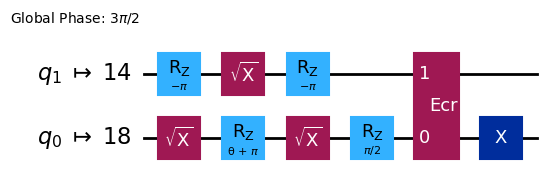

In [82]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuit = pm.run(circuit)
isa_circuit.draw('mpl', idle_wires=False)

In [84]:
isa_obs = observable.apply_layout(isa_circuit.layout)
pub = (isa_circuit, isa_obs, params)

In [86]:
from qiskit_ibm_runtime import EstimatorOptions
options = EstimatorOptions()
options.default_shots = 4000
options.resilience_level = 0

estimator = EstimatorV2(mode=backend, options=options)

No mitigation job ID: cwj869s0r6b0008psn4g

In [87]:
job_no_mit = estimator.run([pub])
print(job_no_mit.job_id())

cwj869s0r6b0008psn4g


In [89]:
job_no_mit = service.job('cwj869s0r6b0008psn4g')

In [90]:
job_no_mit.status()

'DONE'

In [102]:
job_no_mit.metrics()['usage']['quantum_seconds']

47

In [91]:
hw_expvals = []
result = job_no_mit.result()

for i, val in enumerate(params):
    hw_expvals.append(round(result[0].data.evs[i],3))

In [92]:
options = EstimatorOptions()
options.default_shots = 4000
options.resilience_level = 0
options.resilience.measure_mitigation = True
options.twirling.enable_gates = True
options.twirling.enable_measure = True

estimator = EstimatorV2(mode=backend, options=options)

Mitigation job ID: cwj8jtv31we000883wwg

In [93]:
job_mit = estimator.run([pub])
print(job_mit.job_id())

cwj8jtv31we000883wwg


In [94]:
job_mit = service.job('cwj8jtv31we000883wwg')

In [101]:
job_mit.status()

'DONE'

In [103]:
job_mit.metrics()['usage']['quantum_seconds']

82

In [104]:
hw_mit_expvals = []
result = job_mit.result()

for i, val in enumerate(params):
    hw_mit_expvals.append(round(result[0].data.evs[i],3))

/var/folders/29/5g097jln3fx21kr9g9vfc4540000gn/T/ipykernel_18837/782806125.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)


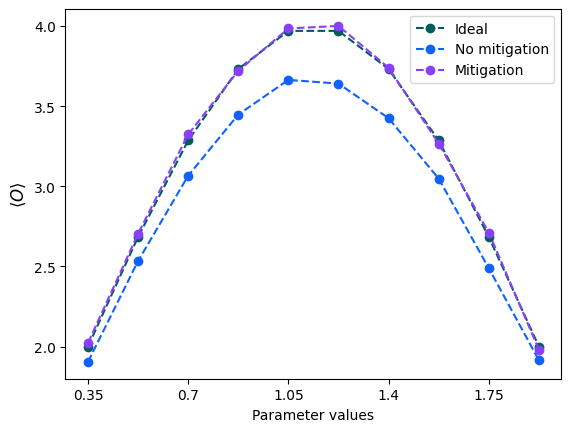

In [106]:
import matplotlib.pyplot as plt

ax = plt.gca()
plt.plot(range(len(params)), ideal_expvals, 'o--', color="#005d5d", label='Ideal')
plt.plot(range(len(params)), hw_expvals, 'o--', color="#0f62fe", label='No mitigation')
plt.plot(range(len(params)), hw_mit_expvals, 'o--', color="#8a3ffc", label='Mitigation')
plt.legend()
ax.set_ylabel(r'$\langle O \rangle$', fontsize=12)

xticks = [round(i,2) for i in params]
ax.set_xticklabels(xticks)
ax.set_xlabel('Parameter values')
plt.show()

### The Sampler Primitive

Next we'll demonstrate using the `Sampler` primitive.  We'll use the same quantum circuit as before, but this time we'll need to add measurement gates. Note that we didn't add measurement gates when using the Estimator primitive.

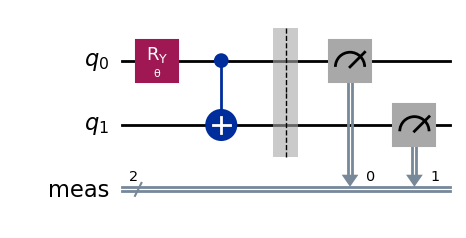

In [108]:
circuit.measure_all()
circuit.draw("mpl")

Now we'll simulate this circuit using the reference Sampler primitive.

In [143]:
from qiskit_aer.primitives import SamplerV2

sampler = SamplerV2()
pub = (circuit, params)

# Now run the job and examine the results
sampler_job = sampler.run([pub])
result = sampler_job.result()[0]

In [144]:
ideal_counts = {}

for i, val in enumerate(params):
    ideal_counts[round(val,2)] = result.data.meas[i].get_counts()

In [145]:
ideal_counts

{0.0: {'00': 1024},
 0.35: {'00': 997, '11': 27},
 0.7: {'11': 106, '00': 918},
 1.05: {'00': 784, '11': 240},
 1.4: {'11': 384, '00': 640},
 1.75: {'11': 594, '00': 430},
 2.09: {'11': 756, '00': 268},
 2.44: {'11': 895, '00': 129},
 2.79: {'11': 996, '00': 28},
 3.14: {'11': 1024}}

Next we'll use the Runtime Sampler to run our circuit on a backend.  Recall that we still need to specify an `IBMBackend` object through the `QisktRuntimeService` and ensure the circuit is written in terms of the backend's ISA.

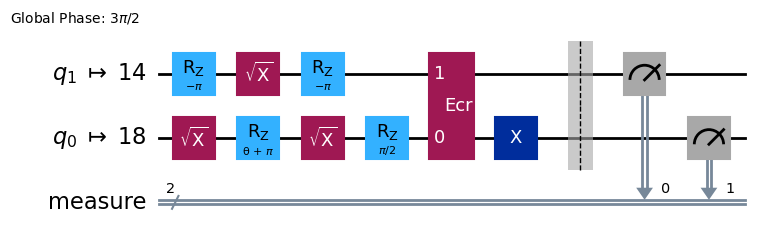

In [118]:
isa_circuit.measure_active()
isa_circuit.draw('mpl', idle_wires=False)

In [167]:
# This import overwrites our previous Sampler import
from qiskit_ibm_runtime import SamplerV2, SamplerOptions, Batch

batch = Batch(backend=backend)

batch ID cwj9scn40e0000890tn0

In [169]:
batch.session_id

'cwj9scn40e0000890tn0'

In [171]:
options = SamplerOptions()
options.twirling.enable_gates = False
options.twirling.enable_measure = False
options.default_shots = 1024
sampler = SamplerV2(mode=batch, options=options)

In [172]:
options.twirling.enable_gates = True
options.twirling.enable_measure = True
twirl_sampler = SamplerV2(mode=batch, options=options)

In [173]:
pub = (isa_circuit, params)

job = sampler.run([pub])
job_twirl = twirl_sampler.run([pub])

In [174]:
batch = Batch(backend=backend).from_id('cwj9scn40e0000890tn0', service)

In [175]:
batch.details()

{'id': 'cwj9scn40e0000890tn0',
 'backend_name': 'ibm_cusco',
 'interactive_timeout': 1,
 'max_time': 86400,
 'active_timeout': 14400,
 'state': 'inactive',
 'accepting_jobs': True,
 'last_job_started': '2024-11-01T09:18:45.833Z',
 'last_job_completed': '2024-11-01T09:19:09.792Z',
 'started_at': '2024-11-01T09:18:44.069Z',
 'closed_at': None,
 'activated_at': '2024-11-01T09:18:44.069Z',
 'mode': 'batch',
 'usage_time': 8}

In [176]:
jobs = service.jobs(session_id='cwj9qg60r6b0008psvv0')
jobs

[<RuntimeJob('cwj9qp60r6b0008psvw0', 'sampler')>,
 <RuntimeJob('cwj9qnpmptp00085rra0', 'sampler')>]

In [179]:
param = params[1]
counts = jobs[0].result()[0].data.measure[1].get_counts()
counts_twirl = jobs[1].result()[0].data.measure[1].get_counts()

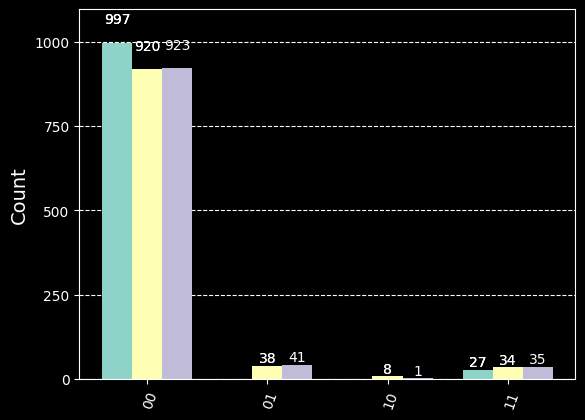

In [180]:
from qiskit.visualization import plot_histogram

plot_histogram([ideal_counts[0.35], counts, counts_twirl])

#### Configuring Runtime options

Oftentimes, the quantum circuits constructed for utility scale algorithms are not well optimized to run on noisy quantum hardware.  In fact, it may even be important to post-process your results using error mitigation techniques.  Fortunately, there are a few ways to implement both error mitigation as well as optimizations of your quantum circuits.

The first is to simply set a few Runtime configuration options; specifically the `optimization_level` and `resilience_level`.  These are both managed and included in a Runtime Primitive using its `.options` attribute or with the `EstimatorOptions` or `SamplerOptions` objects.

The options for `optimization_level` are:

| Optimization Level | Estimator & Sampler |
| :--- | :--- |
| 0 | No optimization: typically used for hardware characterization or debugging <br />    - Basis translation <br /> - Layout (`TrivialLayout`: virtual -> physical)  <br /> - Routing: `StochasticSwap` |
| 1, 2, 3 | Light optimization: <br /> - Layout (trivial → vf2 → SabreLayout if routing is required) <br /> - Routing (SabreSwap if needed) <br /> - 1Q gate optimization <br /> - Error suppression: dynamical decoupling |


And the options for `resilience_level` for the `Estimator` primitives will implement the following error mitigation techniques.

| Resilience Level | Definition | Estimator |
| :--- | :--- | :--- |
|0 | No mitigation	| None |
|1 [Default] |	Minimal mitigation costs: Mitigate error associated with readout errors | Twirled Readout Error eXtinction (TREX)<sup> [1](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.105.032620) </sup>	|
| 2 | Medium mitigation costs. Typically reduces bias in estimators, but is not guaranteed to be zero bias. | Level 1 + Zero Noise Extrapolation (ZNE)<sup>[3,](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.180509)[4](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.7.021050)</sup>  |	


### Resources

If you'd like to learn more about the Qiskit SDK, the Qiskit ecosystem, or tutorials/how-to guides these links will help you along your way.

- Qiskit Documentation: https://docs.quantum.ibm.com/

- Qiskit Ecosystem: https://qiskit.github.io/ecosystem/

- IBM Quantum Learning Platform: https://learning.quantum.ibm.com/

In [3]:
import qiskit
import qiskit_ibm_runtime

print(f'Version of Qiskit is {qiskit.__version__}')
print(f'Version of Qiskit Runtime is {qiskit_ibm_runtime.__version__}')

Version of Qiskit is 1.2.2
Version of Qiskit Runtime is 0.30.0
